### Библиотеки

In [1]:
import pickle

In [2]:
from Experiment_6_part2_advection import *

### Описание эксперимента:

######  - Разбираюсь со сдвигом по врмени

In [3]:
def count_ones(v_coarse,verbose=False):
    
    all_sums=[]
    for j in range(0,len(v_coarse[0,:]),1):
        all_sums.append(v_coarse[:,j].sum())
    
    if verbose:
        print(all_sums)
    assert np.sum(all_sums)%v_coarse.shape[1]==0, 'Неправильно подобран n'
    return all_sums[0]

def check_ones_continuous(v_coarse_orig,ones,verbose=False,plt_flg=False):
    
    v_coarse=copy.copy(v_coarse_orig)
    v_coarse_shifted=v_coarse.T[1:]
    v_coarse=v_coarse.T[:-1]
    diff=v_coarse_shifted-v_coarse
    
    ones=int(ones)
    
    def my_plot(k):
        plt.figure(figsize=(10,6))
        plt.plot(v_coarse[k],'-*',color='red',label='t')
        plt.plot(v_coarse_shifted[k],'--*',color='green',label='t+1')
        plt.title(k)
        plt.legend()
        plt.grid()
        plt.show()
    
    for k in range(len(v_coarse)):
        
        start=np.where(diff[k]==-1)[0]
        end=np.where(diff[k]==1)[-1]
        
        if len(start)==1 or len(end)==1:
            
            start=start[0]
            end=end[0] 
            diff_mask=diff[k][start:end+1]
            
            if plt_flg:
                my_plot(k)
                
            if verbose==True:
                print(start,end)
                print('mask',diff_mask)
            

            if len(diff_mask)!=len(np.array([-1]+[0]*(ones-1)+[1])):
                assert 1==2, 'Не выполняется условие непрерывности (длина)'
            elif (diff_mask!=np.array([-1]+[0]*(ones-1)+[1])).all():
                if verbose:
                    display(diff_mask)
                assert 1==2, 'Не выполняется условие непрерывности (значения)'
        
        elif len(start)>1:
            if plt_flg:
                my_plot(k)
            if verbose==True:
                print(start,end)
            assert 1==2,'stop point 1_start'
            
        elif len(start)<1:
            if plt_flg:
                my_plot(k)
            if verbose==True:
                print(start,end)
            assert 1==2,'stop point 2_start'
                
        elif len(end)>1:
            print()
            if plt_flg:
                my_plot(k)
            if verbose==True:
                print(start,end)
            assert 1==2,'stop point 2_end'
                
        # elif len(end)<1:
        #     print('2_end')
        #     if plt_flg:
        #         my_plot(k)
        
        # else:
            # break

### 0. Параметры для генерации данных

In [4]:
generate_flg=True # True - генерация, False - чтение уже сгенерированных
# generate_flg=False

n=21 #число узлов
L=1 # длина расчт области
T=.85 #конечное время
kurant=1

h=L/(n-1)
b=(n-1)*0.1*L #width % of L (длина участка с v=1, составляет 10% от расчт области)
# b=4
v=[1 if i in range(1,int(b)+1) else 0 for i in range(0,n) ]
print('Доля единиц:',np.round(100*v.count(1)/len(v),3))

Доля единиц: 9.524


In [5]:
# epochs_lst=[1,10,100,1_000,5_000,10_000]
epochs_lst=[1]

### 1. Генерация данных

In [6]:
v_fact,x_lst,tau,time_lst=generate_data_fixe(generate_flg,v,T,L,1,h,n,CUSTOM_TAU=h,save_flg=False)

Генерация данных
17 21
21 17


Text(0.5, 1.0, 'Фактические данные')

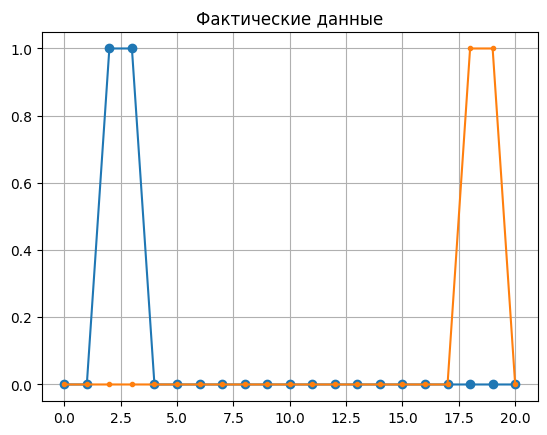

In [7]:
#view
plt.plot(v_fact[:,0],'o-')
plt.plot(v_fact[:,-1],'.-')
plt.grid()
plt.title('Фактические данные')

### 2. Сабсемплинг

In [9]:
t_factor = 1  # time subsample factor 
s_factor = 1  # space subsample factor
Tsim=len(v_fact[0])
dxc,dtc,coarse_t,coarse_x,v_coarse,Lxc,\
Ltc,v_coarse_train,v_coarse_test=subsampling(s_factor,t_factor,h,tau,Tsim,n,v_fact,train_split=train_split)

full_sample (21, 17)
train (21, 8)
test (21, 9)


In [10]:
dxc==dtc, dxc

(True, 0.05)

Text(0.5, 1.0, 'Фактические данные после сабсемплинга')

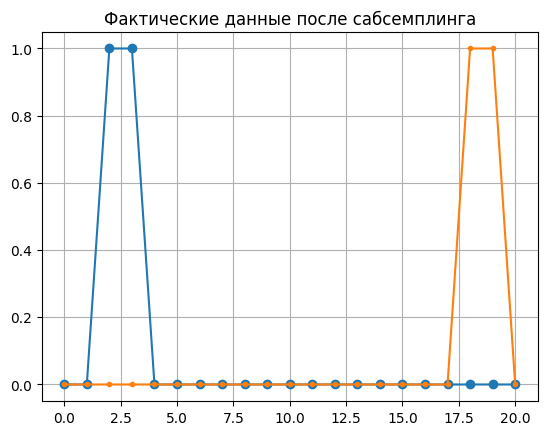

In [11]:
#view
plt.plot(v_coarse[:,0],'o-')
plt.plot(v_coarse[:,-1],'.-')
plt.grid()
plt.title('Фактические данные после сабсемплинга')

In [12]:
ones=count_ones(v_coarse,verbose=True)
count_ones(v_fact,verbose=False)
check_ones_continuous(v_coarse,ones,verbose=False,plt_flg=False)
check_ones_continuous(v_fact,ones,verbose=False,plt_flg=False)

[np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0)]


##### CHECK : проверяю что после сабсемплинга нет сдвига

In [13]:
for i in v_coarse-v_fact:
    if max(i)!=0:
        print(i)

In [14]:
dxc

0.05

### 3. Тренировка модели

In [15]:
for epochs in epochs_lst:
    
    net, loss_lst,loss=train_net(MLPConv,v_coarse_train,epochs,dtc,
              fs,
              neurons,
              hidden_layers_num,
              lr,
              m,
              has_backward,
              method,
              decay_const
             )
    
    pickle.dump(net, open(fr'Experiment_6_part2_advection/models/net_epochs={epochs}', 'wb'))
    

input 3 output 1
#parameters: 3


100%|██████████| 1/1 [00:00<00:00, 42.79it/s, loss=0]


In [16]:
dxc

0.05

### 4. Симуляция прогноза моделью

In [17]:
NN_sim_lst=[]

weights=[]
biases=[]

for epochs in epochs_lst:
    
    net = pickle.load(open(fr'Experiment_6_part2_advection/models/net_epochs={epochs}', 'rb'))
    
    NN_sim,T_sim,x_sim=make_simulation(net,v_coarse,L,Lxc,dtc,method='E1')
    
    NN_sim_lst.append(NN_sim)
    
    weights.append(net.layer[0].weight.data.numpy())
    biases.append(None)

100%|██████████| 16/16 [00:00<?, ?it/s]


In [18]:
pd.DataFrame({'epoch':epochs_lst+[['finite_diff_methods']],
              'coefs':weights+[[1/((dxc)),-1/(dxc),0]],
              'bias':biases+[[None]]})

,epoch,coefs,bias
0,1,"[[20.0, -20.0, 0.0]]",None
1,[finite_diff_methods],"[20.0, -20.0, 0]",[None]


In [19]:
print(dxc)

0.05


### 5. Результаты

---------------Epochs = 1-------------------


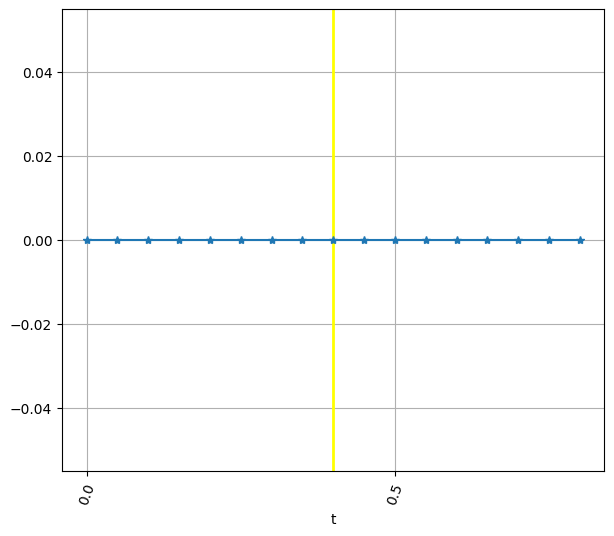



done


In [20]:
# view_results(T_sim,x_sim,NN_sim,v_coarse,T,dtc,n=10,fix_axes=True)

# view_result_imshow(NN_sim,v_coarse,T,dtc,L,dxc,figsize=(10,10))

folder='Experiment_6_part2_advection'

for i in range(len(epochs_lst)):
    
    print(fr'---------------Epochs = {epochs_lst[i]}-------------------')
    view_results(T_sim,x_sim,NN_sim_lst[i],v_coarse,T,dtc,n=10,fix_axes=True,
                epochs=epochs_lst[i],
                save_path = fr'{folder}/graphs2/',
                save_name = fr'Result_epoch={epochs_lst[i]}',
                view_flag=False)
    view_result_metric(NN_sim_lst[i],v_coarse,T,dtc,L,dxc,
                       n_xticks=10,
                       save_path = fr'{folder}/graphs2/',
                save_name = fr'Metric_epoch={epochs_lst[i]}')

    make_gif(folder=fr'{folder}/graphs2/',epochs=epochs_lst[i])

    print('\n')
print('done')

In [21]:
net.layer[0].weight

Parameter containing:
tensor([[ 20., -20.,   0.]], requires_grad=True)

In [22]:
diff=NN_sim_lst[0]-v_coarse

for j in range(len(diff[0,:])): 
    if max(diff[:,j])!=0:
        plt.figure()
        plt.plot(diff[:,j],'-*')
        plt.title(str(j)+' / '+str(len(diff[0,:])))
        plt.grid()
        
        plt.figure()
        plt.plot(NN_sim_lst[0][:,j],'-*',label='NN_sim')
        plt.plot(v_coarse[:,j],'-*',label='v_coarse')
        plt.legend()
        plt.grid()
        
        break

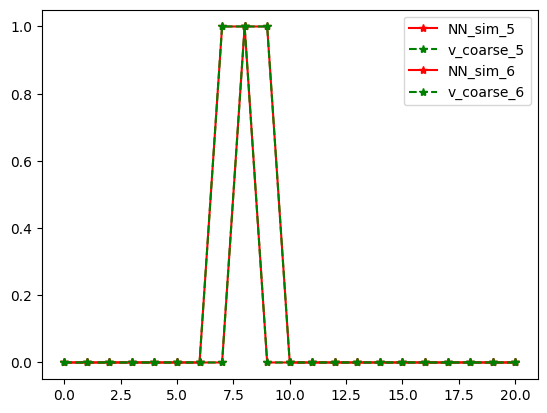

In [23]:
for j in range(5,7):
        plt.plot(NN_sim_lst[0][:,j],'-*',color='red',label=fr'NN_sim_{j}')
        # plt.plot(v_coarse[:,j],'--*',color='blue',label=fr'v_coarse_{j}')
        plt.plot(v_fact[:,j],'--*',color='green',label=fr'v_coarse_{j}')
        plt.legend()
        plt.grid()